# Duffing Equation
The Duffing equation (or Duffing oscillator), named after Georg Duffing (1861–1944), is a non-linear second-order differential equation used to model certain damped and driven oscillators. The equation is given by


\begin{align*}
{\ddot {x}}+\delta {\dot {x}}+\alpha x+\beta x^{3}=\gamma \cos(\omega t)
\end{align*}

where the (unknown) function $x=x(t)$ is the displacement at time t, $ {\dot {x}}$ is the first derivative of $x$ with respect to time, i.e. velocity, and ${\ddot {x}}$ is the second time-derivative of $x$ i.e. acceleration. The numbers
$\delta, \alpha, \beta, \gamma$ and $\omega$ are given constants.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

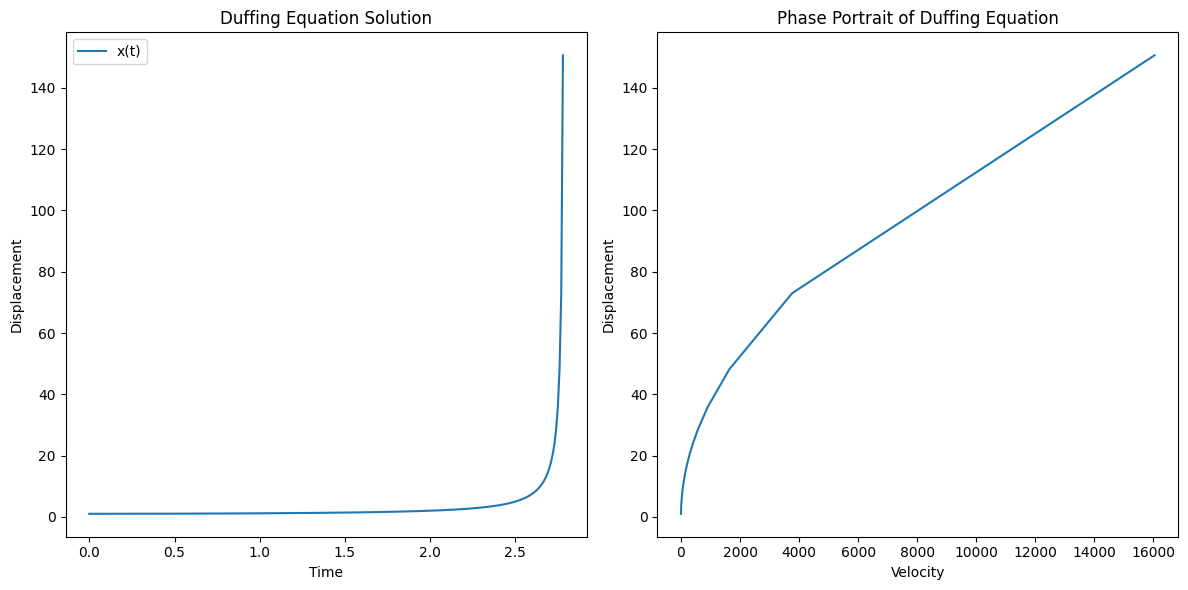

In [2]:
def duffing(t, y, delta, alpha, beta, gamma, omega):
    x, v = y
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return np.array([dxdt, dvdt])

# Simulation parameters
delta = 0.1
alpha = 1.0
beta = -1.0
gamma = 0.3
omega = 1.2

# Initial conditions
x0 = 1.0
v0 = 0.0
y0 = [x0, v0]

# Run the simulation
# Time span
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the Duffing equation
sol = solve_ivp(duffing, t_span, y0, args=(delta, alpha, beta, gamma, omega), t_eval=t_eval)

# Plot the solution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Duffing Equation Solution')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(sol.y[1], sol.y[0])
plt.xlabel('Velocity')
plt.ylabel('Displacement')
plt.title('Phase Portrait of Duffing Equation')

plt.tight_layout()
plt.show()

In [3]:
def ekf_predict(x, P, Q, dt, mu):
    """
    EKF Predict Step.
    """
    # State prediction
    F = np.array([[1, dt],
                  [-mu * dt, 1 - mu * dt]])
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q


    return x_pred, P_pred

def ekf_update(x_pred, P_pred, z, R, H):
    """
    EKF Update Step.

    """
    # Measurement residual
    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = P_pred - K @ H @ P_pred

    return x_upd, P_upd

# Example usage
dt = 0.01  # Time step
mu = 0.2  # Nonlinearity parameter
x = np.array([0.0, 2.0])  # Initial state estimate
P = np.eye(2) * 0.1  # Initial state covariance
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.eye(1) * 0.1  # Measurement noise covariance
H = np.array([[1, 0]])  # Measurement matrix

# Simulate a single predict-update cycle
x_pred, P_pred = ekf_predict(x, P, Q, dt, mu)
# Assuming a measurement of the position
z = np.array([1.95])  # Example measurement
x_upd, P_upd = ekf_update(x_pred, P_pred, z, R, H)

print("Updated State:", x_upd)
print("Updated Covariance:\n", P_upd)


Updated State: [1.03099614 2.00333365]
Updated Covariance:
 [[0.05238322 0.00037998]
 [0.00037998 0.10959777]]


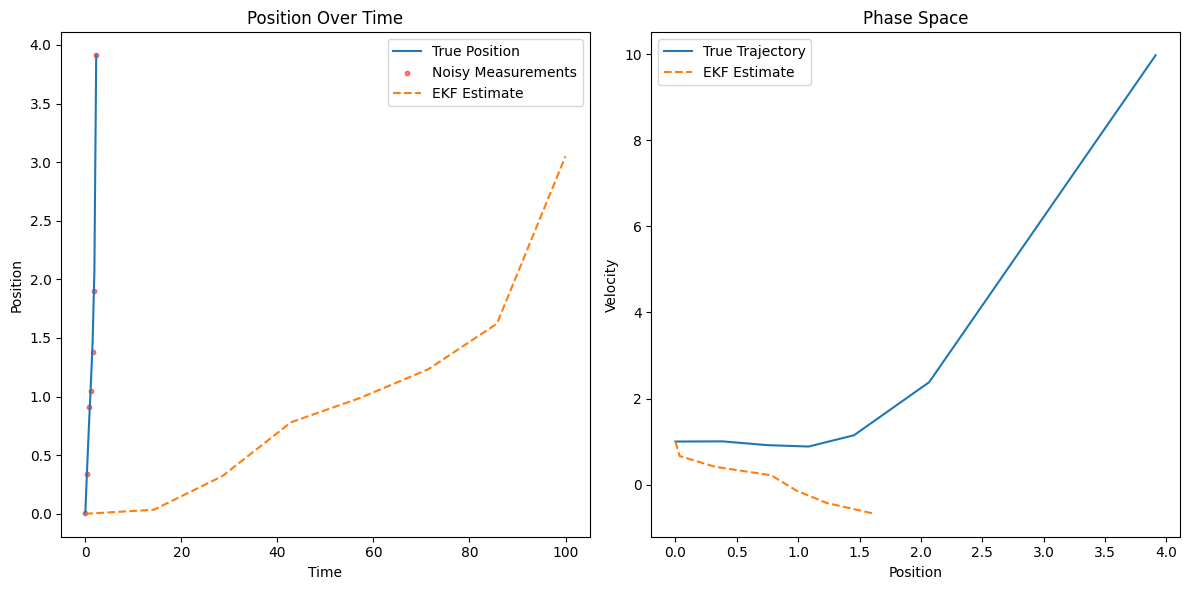

In [4]:
# Parameters for Duffing oscillator
delta = 0.1
alpha = 1.0
beta = -1.0
gamma = 0.3
omega = 1.2

# Simulation parameters
t0 = 0
t1 = 100
n = 265
ts = np.linspace(t0, t1, n)
dt = (t1 - t0) / n
mu = 1.0  # Nonlinearity parameter

# Generate true trajectory using the Duffing equation
true_sol = solve_ivp(duffing, [t0, t1], [0.0, 1.0], args=(delta, alpha, beta, gamma, omega), t_eval=ts)
true_ys = true_sol.y.T

# Measurement parameters
measurement_noise_std = 0.1
noisy_measurements = true_ys[:, 0] + np.random.normal(0, measurement_noise_std, size=true_ys[:, 0].shape)

# Initialize EKF
x_ekf = np.array([0.0, 1.0])  # Initial state estimate (same as true initial condition for simplicity)
P = np.eye(2) * 0.1  # Initial state covariance
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.array([[measurement_noise_std ** 2]])  # Measurement noise covariance
H = np.array([[1, 0]])  # Measurement matrix

# Store EKF estimates for plotting
ekf_estimates = [x_ekf]

# EKF over multiple steps
for z in noisy_measurements:
    # Prediction step
    x_pred, P_pred = ekf_predict(x_ekf, P, Q, dt, mu)

    # Update step with simulated measurement
    z_arr = np.array([z])  # Measurement vector
    x_upd, P_upd = ekf_update(x_pred, P_pred, z_arr, R, H)

    # Store update and prepare for next iteration
    ekf_estimates.append(x_upd)
    x_ekf, P = x_upd, P_upd

# Convert list of EKF estimates to array for plotting
ekf_estimates = np.array(ekf_estimates)

# Interpolate EKF estimates to match the time points
interp_func = interp1d(np.linspace(t0, t1, len(ekf_estimates)), ekf_estimates[:, 0], kind='linear')

# Plotting
plt.figure(figsize=(12, 6))

# True trajectory and noisy measurements
plt.subplot(1, 2, 1)
plt.plot(true_sol.t, true_ys[:, 0], label='True Position')
plt.scatter(true_sol.t, noisy_measurements, s=10, color='red', label='Noisy Measurements', alpha=0.5)
plt.plot(ts, interp_func(ts), label='EKF Estimate', linestyle='--')
plt.title('Position Over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

# Phase space - True vs. EKF Estimate
plt.subplot(1, 2, 2)
plt.plot(true_ys[:, 0], true_ys[:, 1], label='True Trajectory')
plt.plot(ekf_estimates[:-1, 0], ekf_estimates[:-1, 1], label='EKF Estimate', linestyle='--')
plt.title('Phase Space')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()

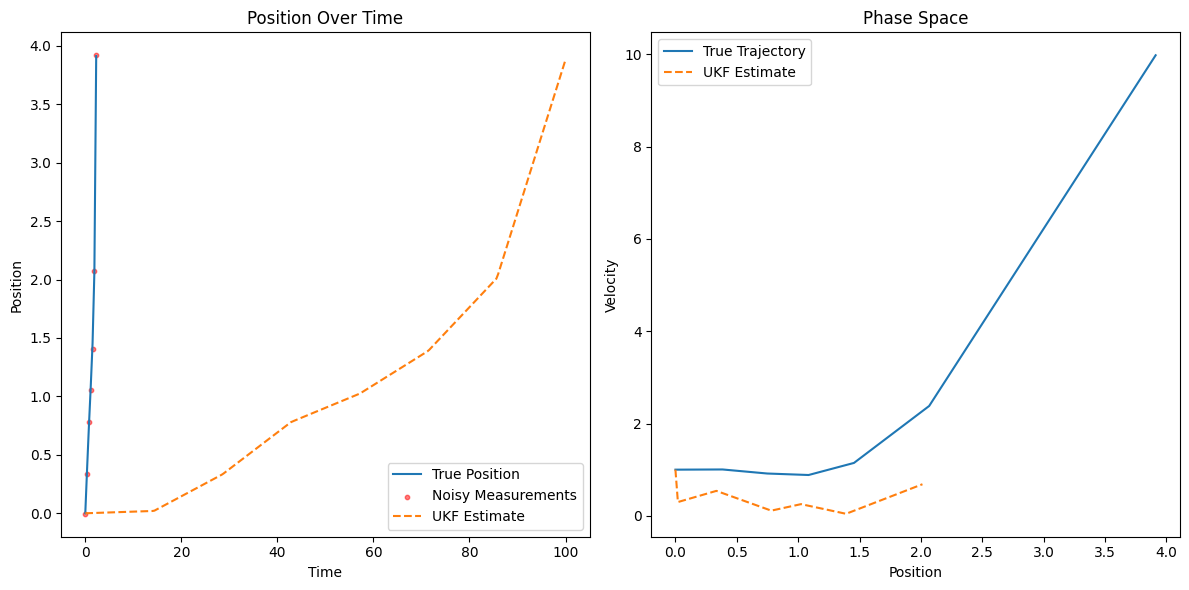

In [6]:
def generate_sigma_points(x, P, alpha, ki, beta):
    """
    Generate sigma points around the current estimate.
    """
    n = x.shape[0]
    lambda_ = alpha**2 * (n + ki) - n
    sigma_points = np.zeros((2 * n + 1, n))
    wm = np.zeros(2 * n + 1)
    wc = np.zeros(2 * n + 1)
    c = np.sqrt(n + lambda_)
    W = c * np.linalg.cholesky(P)
    sigma_points[0] = x
    for i in range(n):
        sigma_points[i + 1] = x + W[:, i]
        sigma_points[n + i + 1] = x - W[:, i]
    # Weights for mean and covariance
    wm.fill(1 / (2 * (n + lambda_)))
    wc.fill(1 / (2 * (n + lambda_)))
    wm[0] = lambda_ / (n + lambda_)
    wc[0] = lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    return sigma_points, wm, wc

def ukf_predict(sigma_points, wm, wc, Q, dt, mu):
    """
    Predict next state and covariance from sigma points.
    """
    n = sigma_points.shape[1]
    # Propagate sigma points through dynamics
    for i in range(sigma_points.shape[0]):
        sigma_points[i] = duffing(0, sigma_points[i], delta, alpha, beta, gamma, omega)
    # Predicted state mean
    x_pred = np.dot(wm, sigma_points)
    # Predicted state covariance
    P_pred = Q.copy()
    for i in range(2 * n + 1):
        diff = sigma_points[i] - x_pred
        P_pred += wc[i] * np.outer(diff, diff)
    return x_pred, P_pred, sigma_points

def ukf_update(x_pred, P_pred, sigma_points, z, R, H, wm, wc):
    """
    Update state and covariance estimates based on measurement.
    """
    n = x_pred.shape[0]
    zs = np.dot(H, sigma_points.T)

    # Calculate predicted measurement covariance (Pz) correctly
    z_pred = np.dot(wm, zs.T)  # Predicted measurement mean, ensuring correct matrix operations
    Pz = R.copy()
    for i in range(2 * n + 1):
        diff = zs[:, i] - z_pred
        Pz += wc[i] * np.outer(diff, diff)

    # Now, ensure Pxz calculation is aligned with the dimensions
    Pxz = np.zeros((n, H.shape[0]))  # Ensure correct dimensionality
    for i in range(2 * n + 1):
        Pxz += wc[i] * np.outer(sigma_points[i] - x_pred, zs[:, i] - z_pred)
    K = np.dot(Pxz, np.linalg.inv(Pz))  # Kalman gain
    x_upd = x_pred + np.dot(K, (z - z_pred))  # Updated state estimate
    P_upd = P_pred - np.dot(K, np.dot(Pz, K.T))  # Updated covariance estimate
    return x_upd, P_upd

# Parameters for Duffing oscillator
delta = 0.1
alpha = 1.0
beta = -1.0
gamma = 0.3
omega = 1.2

# Generate true trajectory using the Duffing equation
true_sol = solve_ivp(duffing, [t0, t1], [0.0, 1.0], args=(delta, alpha, beta, gamma, omega), t_eval=ts)
true_ys = true_sol.y.T

# Measurement parameters
measurement_noise_std = 0.05
noisy_measurements = true_ys[:, 0] + np.random.normal(0, measurement_noise_std, size=true_ys[:, 0].shape)

# Initialize UKF state and covariance (as would be done in practice)
x_ukf = np.array([0.0, 1.0])  # Assuming the initial state estimate is similar for simplicity
P_ukf = np.eye(2) * 0.1  # Initial state covariance

# Generate sigma points
sigma_points, wm, wc = generate_sigma_points(x_ukf, P_ukf, alpha=0.001, ki=0, beta=2)

# UKF over multiple steps
ukf_estimates = [x_ukf]
for z in noisy_measurements:
    # Prediction step
    x_pred, P_pred, sigma_points = ukf_predict(sigma_points, wm, wc, np.eye(2) * 0.01, dt, mu)

    # Update step with simulated measurement
    z_arr = np.array([z])  # Measurement vector
    x_upd, P_upd = ukf_update(x_pred, P_pred, sigma_points, z_arr, np.array([[measurement_noise_std ** 2]]), np.array([[1, 0]]), wm, wc)

    # Store update and prepare for next iteration
    ukf_estimates.append(x_upd)
    x_ukf, P_ukf = x_upd, P_upd

# Convert list of UKF estimates to array for plotting
ukf_estimates = np.array(ukf_estimates)

from scipy.interpolate import interp1d

# Interpolate UKF estimates to match the time points
interp_func = interp1d(np.linspace(t0, t1, len(ukf_estimates)), ukf_estimates[:, 0], kind='linear')

# Plotting
plt.figure(figsize=(12, 6))

# True trajectory and noisy measurements
plt.subplot(1, 2, 1)
plt.plot(true_sol.t, true_ys[:, 0], label='True Position')
plt.scatter(true_sol.t, noisy_measurements, s=10, color='red', label='Noisy Measurements', alpha=0.5)
plt.plot(ts, interp_func(ts), label='UKF Estimate', linestyle='--')
plt.title('Position Over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()

# Phase space - True vs. UKF Estimate
plt.subplot(1, 2, 2)
plt.plot(true_ys[:, 0], true_ys[:, 1], label='True Trajectory')
plt.plot(ukf_estimates[:-1, 0], ukf_estimates[:-1, 1], label='UKF Estimate', linestyle='--')
plt.title('Phase Space')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.legend()

plt.tight_layout()
plt.show()
